<a href="https://colab.research.google.com/github/unoeyh/works/blob/main/airbnb_ny_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb listings price analysis

 Airbnb was one of the prominent examples of successful sharing economy business since it has started its business in 2008. The users - guests used this platform to find more local, unique and personal travel experience. Airbnb successfully matched these demands with the host - people who want to make profits with from their spare room to whole estate. On this project, we are focusing on Airbnb listings in NYC. Using open data on kaggle, we will take a look of the listings in terms of their price, type, and the location. This data describes the listing activity in 2019.
 
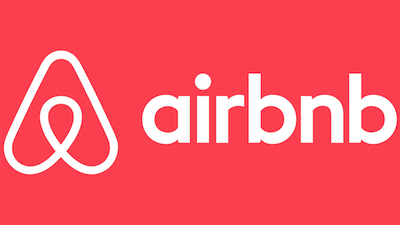

Acknowledgements
This public dataset is part of Airbnb, and the original source can be found on this website.
(https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes  import  MultinomialNB 
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

### 1. The data

Firstly we will import csv file as a pandas data frame and find out basic attributes.

In [2]:
# import cvs file as a pandas data frame
df = pd.read_csv('contents/AB_NYC_2019.csv')

# see the shape of the dataframe - how many listings are there in this data
df.shape

(48895, 16)

In [3]:
# take a look at the first few rows
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


We can see that this data fram consists of 48895 rows and 16 columns. 
Each observation has the information of the host, the location, and the price.</br>
At the same time, we can find some NaN values which we should be careful about during our analysis process.

### 2. Cleaning the data

We already have seen there are some values missing in the dataframe. The first case was one with no review. Since it has 0 response, the values in the columns 'last_review' and 'reviews_per_month' have null values. 

In [4]:
# check the number of columns that have 'Null' values in them
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In this analysis, we will focus more on the relationship between the price and the location of the listings. Therefore, we firstly exclude some information that is not related to our analysis. In order to do that, we will delete columns that are not necessary. Then, we will again take a look at the missing values in the data frame.

In [5]:
# The name, ID and the host name of the listing is not related to the price of the listings
# Therefore it is appropriate to exclude the information

df.drop(['name','id','host_name','last_review','reviews_per_month'], axis=1, inplace=True)

In [6]:
# count the null values again

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         48895 non-null  int64  
 1   neighbourhood_group             48895 non-null  object 
 2   neighbourhood                   48895 non-null  object 
 3   latitude                        48895 non-null  float64
 4   longitude                       48895 non-null  float64
 5   room_type                       48895 non-null  object 
 6   price                           48895 non-null  int64  
 7   minimum_nights                  48895 non-null  int64  
 8   number_of_reviews               48895 non-null  int64  
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 4.1+ MB


Fortunally, after dropping the columns about the host names and the number of reviews, we see all the rows have non-null values. Now we will check the possibility of duplicates and outliers.

In [7]:
# check whether there are duplicated observation
df.duplicated().sum()

0

In [8]:
# check the minimum value of the each column
df.min()

host_id                                      2438
neighbourhood_group                         Bronx
neighbourhood                            Allerton
latitude                                  40.4998
longitude                                -74.2444
room_type                         Entire home/apt
price                                           0
minimum_nights                                  1
number_of_reviews                               0
calculated_host_listings_count                  1
availability_365                                0
dtype: object

In [10]:
# sort the dataframe on price, from the lowest to the highest

df.sort_values('price', ascending = True)

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
25796,86327101,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,6,222
25634,15787004,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,5,0
25433,131697576,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,4,127
25753,1641537,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2,0
23161,8993084,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,4,28
...,...,...,...,...,...,...,...,...,...,...,...
40433,4382127,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999,30,0,1,365
12342,3906464,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,1,83
17692,5143901,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,1,0
9151,20582832,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,1,0


According to the data frame, there are even people who offers free accomodation in NYC!!
It is nice that we have philanthropist but outliers are not the most pleasant thing in our analysis.
Also there are listings with 10000 dollar bills, which does not look very realistic.

Therefore we will only consider the group with 3 standard devision from the mean.

In [11]:
# calculate summary statistics
df_mean = np.mean(df['price'])
df_std = np.std(df['price'])

# identify outliers
cut_off = df_std * 3
lower = df_mean - cut_off
upper = df_mean + cut_off

In [12]:
print('mean :',df_mean,' standard deviation :',df_std)

mean : 152.7206871868289  standard deviation : 240.1517139194169


In [13]:
df_cleaned = df[(df['price'] > lower) & (df['price'] < upper)]
df_cleaned.sort_values('price')

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
25433,131697576,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,4,127
25794,86327101,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,6,176
25795,86327101,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,6,232
25753,1641537,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2,0
25634,15787004,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,5,0
...,...,...,...,...,...,...,...,...,...,...,...
36536,145981682,Manhattan,Theater District,40.75866,-73.98535,Entire home/apt,850,1,24,3,269
19183,26830685,Manhattan,SoHo,40.72575,-74.00128,Entire home/apt,850,3,32,1,262
28141,35743804,Manhattan,Financial District,40.70758,-74.00409,Entire home/apt,850,1,16,1,174
37341,68198631,Brooklyn,Prospect-Lefferts Gardens,40.66354,-73.95507,Entire home/apt,860,2,4,1,23


However, We can still see the free listings. This is because standard deviation of the price is even larger than its mean. Even though the scikit learn library offers outlier classification, for this current analysis, we will simply leave those listings out. And this leaves 48496 out of 48895 observations. which is more than 99% of the original observations.

In [14]:
# delete listings have 0 price

df_cleaned = df_cleaned[(df_cleaned['price'] > 0)]
df_cleaned.sort_values('price')

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
31407,91034542,Manhattan,Kips Bay,40.74408,-73.97803,Private room,10,5,42,1,2
22287,84497333,Manhattan,SoHo,40.72237,-73.99817,Private room,10,5,2,1,0
33505,110049861,Brooklyn,Williamsburg,40.70959,-73.95693,Private room,10,1,0,1,83
2860,2196224,Manhattan,East Village,40.73051,-73.98140,Entire home/apt,10,30,0,4,137
27972,11967922,Brooklyn,Greenpoint,40.72421,-73.95364,Entire home/apt,10,1,93,1,32
...,...,...,...,...,...,...,...,...,...,...,...
16140,5302382,Manhattan,Chelsea,40.74574,-73.99633,Entire home/apt,850,2,10,1,10
662,1314834,Manhattan,Greenwich Village,40.73129,-73.99944,Entire home/apt,850,3,107,1,249
22586,126311719,Manhattan,SoHo,40.72390,-73.99678,Entire home/apt,850,30,7,1,365
37341,68198631,Brooklyn,Prospect-Lefferts Gardens,40.66354,-73.95507,Entire home/apt,860,2,4,1,23


### 3. Descriptive statistics and data visualization

We will take a look at the dataframe and check its descriptive statistics. On top of that, the visualization of those statistics will lead us better understaing of the data.

In [15]:
# To show several statistics such as mean, standard deviation and median of prices in the data frame

df_cleaned['price'].describe()

count    48496.000000
mean       138.778373
std        107.550128
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        860.000000
Name: price, dtype: float64

The average airbnb price of the listings in New York was 139 dollars in 2019.

From now, we will see the statistics based on the neighborhood.

In [16]:
# count the number of the listings based on the neighborhoods

df_cleaned.groupby('neighbourhood_group')['neighbourhood_group'].count()

neighbourhood_group
Bronx             1088
Brooklyn         20011
Manhattan        21377
Queens            5650
Staten Island      370
Name: neighbourhood_group, dtype: int64

<AxesSubplot:xlabel='neighbourhood_group', ylabel='count'>

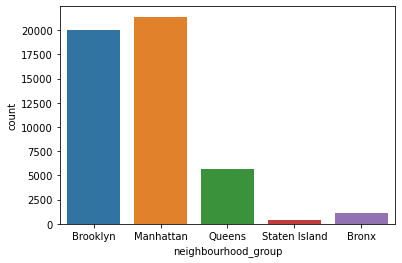

In [17]:
# plot the counts of listings of each disctict('neighbourhood group' in this data)

sns.countplot(x = "neighbourhood_group", data = df_cleaned)

Manhattan has the most listing, followed by Brookly which has the neck-and-neck number of listings. We can see both regions take the most of portion. Staten Island has the lowest number.

Now we will see the price range of each region.

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

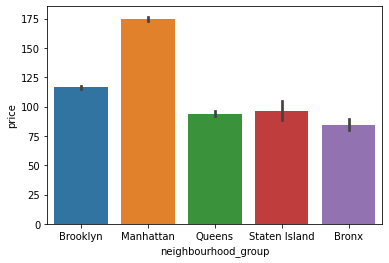

In [18]:
# plot the price range of each neighbourhood

sns.barplot(y="price", x = "neighbourhood_group", data = df_cleaned)

Manhattan is definately the most expensive area, while other distict have similar price range between 75 and 125
Noticeably, Staten Island has a high variation of price range.

now we will see the visualization based on room-type

In [19]:
# count the number of listings based on room types

df_cleaned.groupby('room_type')['room_type'].count()

room_type
Entire home/apt    25100
Private room       22242
Shared room         1154
Name: room_type, dtype: int64

<AxesSubplot:xlabel='room_type', ylabel='count'>

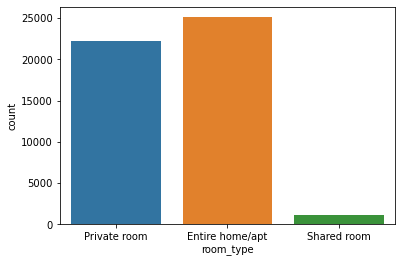

In [20]:
# plot the bar-chart of listing counts, respect to the room types

sns.countplot(x = 'room_type', data = df_cleaned)

There are very few number of shared room type listings
The entire room has the highest number, the second most common category is private room type with a relatively small gap



<AxesSubplot:xlabel='room_type', ylabel='price'>

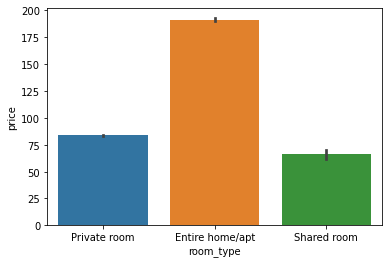

In [21]:
# plot the price range in terms of the room type
sns.barplot(y="price", x="room_type", data = df_cleaned)

Private rooms have the price slight under 100 dollars, while the Entire apartment type has the proce range above 200 dollars.Shared room type has the most affordable budget range but the gap with private room is not too large.

Finally we will see the bar chart combining the room type and the neighborhood.

In [22]:
# make a new column on the dataframe, combining the room type and the neighborhood

df_cleaned["neigh_room"] = df['room_type'] + ' in ' + df["neighbourhood_group"]
df_cleaned.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neigh_room
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,Private room in Brooklyn
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,Entire home/apt in Manhattan
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,Private room in Manhattan
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194,Entire home/apt in Brooklyn
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,Entire home/apt in Manhattan


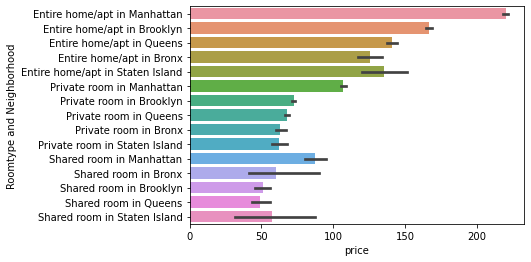

In [23]:
# plot the barchart

fig = sns.barplot(x="price", y = "neigh_room", data = df_cleaned.sort_values('room_type'))
fig.set(ylabel='Roomtype and Neighborhood')
plt.show()

Now, we can see the clearer pattern. If you want to stay in an entire flat, you have to relatively pay more. The combination of Manhattan and the entire flat type is most expensive with no doubt, and even shared room in manhattan was more expensive than private rooms in other neighborhood. 

### 4. Price prediction of the listings

In this chapter, we will predict the price of airbnb listings based on the information we have. In order to analyse the relationship between features, we need to encode categorical variables such as the name of neighbourhood. Here, we use Label Encoder. 

In [24]:
class_le = LabelEncoder()

# encode label: neighbourhood
df_cleaned["loc"] = class_le.fit_transform(df_cleaned["neighbourhood"].values)

#encode label: room type
df_cleaned["type"] = class_le.fit_transform(df_cleaned["room_type"].values)

df_cleaned.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neigh_room,loc,type
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,Private room in Brooklyn,108,1
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,Entire home/apt in Manhattan,127,0
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,Private room in Manhattan,94,1
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194,Entire home/apt in Brooklyn,41,0
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,Entire home/apt in Manhattan,61,0


We will use minimum nights, host listings, availability, location and the room type as control variables. Thus, we drop other columns such as host_id. In this stage, we should also drop the columns such as 'neighbourhood' and 'room_type'. This is because we made the new columns by encoding this information.

In [25]:
# drop columns
X = df_cleaned.drop(["host_id","room_type","neighbourhood",'neigh_room',"neighbourhood_group","latitude","longitude","price"],axis=1)

# define a dependent variable
Y = df_cleaned["price"]

X.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,loc,type
0,1,9,6,365,108,1
1,1,45,2,355,127,0
2,3,0,1,365,94,1
3,1,270,1,194,41,0
4,10,9,1,0,61,0


We will use linear regression method and decision tree method for this stage. Firstly, we need split data into test and train sets.

In [26]:
# Split dataset into train and test sets

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25, random_state=42)

We will process linear regression first, and then use decision tree logic. R-squared and Root mean squared errer will be used to measure the accuracy of the modeling.

In [27]:
# linear regression modeling

lr = LinearRegression().fit(x_train, y_train)

pred_lr = lr.predict(x_test)

# print accuracy
print('R-squared :' + str(metrics.r2_score(y_test,pred_lr)))
print('RMSE :' + str(np.sqrt(metrics.mean_squared_error(y_test,pred_lr))))

R-squared :0.2755582684720963
RMSE :93.5575929138014


In [31]:
# Comparing the real data and the predicted one

err = pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
err['prediction']=np.array(pred_lr)
err.sample(10)

,actual,prediction
2292,299,193.025013
5357,250,189.685078
5838,50,66.772858
2077,150,93.986187
8062,75,92.822134
2314,100,178.681211
5968,140,210.369638
6735,103,225.313536
2755,120,81.951931
1003,150,199.870347


In [29]:
# decision tree regression modeling

dt = DecisionTreeRegressor().fit(x_train,y_train)
pred_dt = dt.predict(x_test)

print('R-squared :' + str(metrics.r2_score(y_test,pred_dt)))
print('RMSE :' + str(np.sqrt(metrics.mean_squared_error(y_test,pred_dt))))

R-squared :-0.03617027431635056
RMSE :111.89041229772502


In [32]:
# Comparing the actual data and the prediction

err = pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
err['prediction']=np.array(pred_dt)
err.sample(10)

,actual,prediction
6938,90,79.600000
10358,49,83.500000
2709,65,40.000000
155,199,240.000000
11351,99,117.500000
8138,250,135.000000
5819,185,175.000000
3288,275,146.666667
2607,303,271.000000
5446,55,47.000000


Unfortunately, we got bad scores. Both regression methods gave us disappointing accuracy results. Then we only consider location and room types for the following prediction.

In [33]:
# select only two factors - columns

X1 = X[["loc","type"]]

In [34]:
# split data into train and test sets

x_train,x_test,y_train,y_test=train_test_split(X1,Y,test_size=0.25, random_state=42)

In [35]:
# apply linear regression modeling

lr = LinearRegression().fit(x_train, y_train)
pred_lr = lr.predict(x_test)

# print accuracy scores

print('R-squared :' + str(metrics.r2_score(y_test,pred_lr)))
print('RMSE :' + str(np.sqrt(metrics.mean_squared_error(y_test,pred_lr))))

R-squared :0.24638944454208433
RMSE :95.42250119425032


In [36]:
# print the difference between the actual values and the predicted values

err = pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
err['prediction']=np.array(pred_lr)
err.sample(10)

,actual,prediction
1306,35,84.549772
10279,49,81.582996
7005,129,184.523601
11059,139,174.881580
5811,90,94.191794
4219,120,199.728328
9488,70,86.898470
7923,80,86.033160
3528,150,183.905523
10520,90,179.578975


In [37]:
# apply decision tree regression modeling

dt = DecisionTreeRegressor().fit(x_train,y_train)
pred_dt = dt.predict(x_test)

# print accuracy scores
print('R-squared :' + str(metrics.r2_score(y_test,pred_dt)))
print('RMSE :' + str(np.sqrt(metrics.mean_squared_error(y_test,pred_dt))))

R-squared :0.3718273705770534
RMSE :87.11978889198576


In [38]:
# print the difference between the actual values and the predicted values

err = pd.DataFrame(np.array(y_test).flatten(),columns=['actual'])
err['prediction']=np.array(pred_dt)
err.sample(10)

,actual,prediction
2304,89,107.575203
4143,295,150.361511
5036,77,147.343880
477,170,142.286561
6568,145,147.343880
730,100,127.056075
5424,308,197.922912
9787,100,197.922912
839,198,237.614499
7868,155,147.343880


### 5. Conclusion

So far, we have looked the price data of airbnb listings in NYC. Statistics shows that what people usually believe is usually true, which is Manhattan is the most expensive area and borrowing entire property is costly. However, we also withnessed interesting factors that even shared rooms in Manhattan tend to more expensive than private rooms in the other neighbourhood in New York. 

Price prediction was not satisfying though. Even after we excluded extreme cases, we got a inferior result overall. When we only consider the location and the room type, the score got lowered.